In [166]:
import geopandas as gpd
import fiona
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation
import numpy as np
from math import sin, cos, sqrt, atan2, radians

In [57]:
#create a list of layers with in a file geodatabase 
layerlist = fiona.listlayers('./Schienennetz_LV03_20171210.gdb')
#print(layerlist)
netzknoten = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzknoten')
netzknoten = netzknoten.to_crs(epsg = 4326)
#display(netzknoten.head())
netzsegment = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzsegment')
#display(netzsegment.head())

In [173]:
#The nodes have their name and geometry(location) associated
G = nx.Graph()
for index, row in netzknoten.iterrows():
    G.add_node(row.xtf_id, geometry = row.geometry, name = row.Betriebspunkt_Name)
    
for index, row in netzsegment.iterrows():
    G.add_edge(row.rAnfangsknoten, row.rEndknoten)

degree_sequence = [d for n, d in G.degree()]
print("Lowest degree in Network= ",min(degree_sequence))
print("Amount of Nodes in the Network",len(G.nodes()))

Lowest degree in Network=  0
Amount of Nodes in the Network 3190


In [174]:
#Remove nodes which are not connected to any other node (degree = 0)
nodes = G.nodes()

to_delete = []
for n in nodes:
    if G.degree(n) == 0:
        to_delete.append(n)
for n in to_delete:
    G.remove_node(n)

degree_sequence = [d for n, d in G.degree()]
print("Lowest degree in Network= ",min(degree_sequence))
print("Amount of Nodes in the Network",len(G.nodes()))

Lowest degree in Network=  1
Amount of Nodes in the Network 3186


In [100]:
#Function to calculate the distance between two coordinate points
def calculate_distance(x1,y1,x2,y2):
    # approximate radius of earth in km
    R = 6373.0
    lon1 = radians(x1)
    lat1 = radians(y1)
       
    lon2 = radians(x2)
    lat2 = radians(y2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

#Function to add on component to the giant component of a network.
# With the curren implementation two nodes with degree 1 are randomly selected and connected to the nearest node in the giant component.

def connect_components(G,component):
    geometries = nx.get_node_attributes(G, "geometry")
    names = nx.get_node_attributes(G, "name")
    largest_cc = max(nx.connected_components(G), key=len)
    one_node_list = []
    for node in component:
        if G.degree(node) == 1:
            one_node_list.append(node)
    
    for i in range(2):
        from_node = random.choice(one_node_list)
        one_node_list.remove(from_node)
        min_distance = 99999999
        for node_id in largest_cc:
            distance = calculate_distance(geometries[node_id].x,geometries[node_id].y, geometries[from_node].x,geometries[from_node].y)
            if distance < min_distance:
                min_distance = distance
                to_node = node_id
        G.add_edge(from_node, to_node)
        
        print("node added from "+ names[from_node] + " to " +names[to_node] )
        
        
            

In [175]:
# Adding two edges from every component to the giant component. Starting with the largest components.
connected_components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

for component in connected_components[1:]:
    connect_components(G,component)


node added from Zürich, Rehalp (Wds) to Zürich Tiefenbrunnen
node added from Zürich, Auzelg (Wds) to Opfikon Süd
node added from Basel, Neuweilerstrasse to Basel SBB West (Abzw)
node added from Basel, Depot Dreispitz to Basel Dreispitz
node added from Scuol-Tarasp to Trimmis (Spw)
node added from Realp DFB to Gotthard Nord (Spw)
node added from Bern Wankdorf, Bahnhof (Wds) to Bern Wankdorf (Gl. 301 + 401)
node added from Bern, Saali to Gümligen
node added from Genève, Nations (boucle) to Genève-Sécheron
node added from Meyrin, Gravière fin de voie to Vernier-Meyrin Cargo
node added from Luzern Brünig to Luzern
node added from Innertkirchen MIB to Gletsch
node added from Leysin-Feydey to Aigle
node added from Les Diablerets to La Chaudanne-Les Moulins
node added from Altstätten Stadt to Altstätten SG
node added from Gossau SG AB to Gossau SG
node added from Solothurn [Gleis 21] to Solothurn [Gleis 9-10]
node added from St. Urban Ziegelei to Roggwil-Wynau
node added from Schöftland to Kö

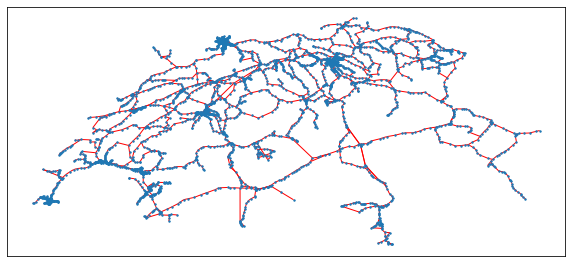

In [128]:
# Plot the network on the Swiss map using the network location data
def show_network(G):
    geometries = nx.get_node_attributes(G, "geometry")
    for key in geometries:
        geometries[key] = [float(geometries[key].x),float(geometries[key].y)]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')

    nx.draw_networkx(G,pos = geometries ,with_labels= False, node_size = 2, edge_color = "r", labels = nx.get_node_attributes(G, "name"))
    plt.show()
show_network(G)



In [104]:
#Some figures for the network: average degree <k>, global clustering coefficient C, assortativity etc.
degree_sequence = [d for n, d in G.degree()]

average_degree = sum(degree_sequence)/len(degree_sequence)
print("average degree ⟨k⟩ =",average_degree)

C = sum(nx.clustering(G).values())/len(nx.clustering(G).values())
print("global clustering C=", C)

assortativity = nx.degree_assortativity_coefficient(G)
print("assortativity=",assortativity)

print("number of connected components= ", nx.number_connected_components(G))

largest_cc = max(nx.connected_components(G), key=len)
number_largest_cc = len(largest_cc) 
number_nodes = len(G.nodes())
print("Amount of nodes in the giant component: ", number_largest_cc)
print("Relative size of the giant component to the full network =", number_largest_cc/number_nodes)

average degree ⟨k⟩ = 2.157564344005022
global clustering C= 0.015840632130650973
assortativity= 0.16401265933044915
number of connected components=  1
Amount of nodes in the giant component:  3186
Relative size of the giant component to the full network = 1.0


[0, 145, 2517, 428, 78, 13, 3, 1, 0, 1]


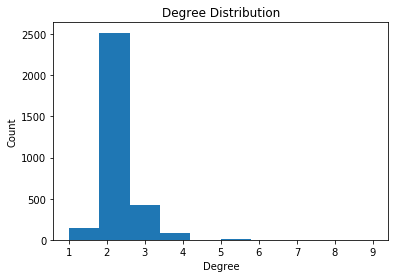

In [105]:
#Degree Distribution of the network
hist = nx.degree_histogram(G)
print(hist)
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.hist(degree_sequence, bins = len(hist))
                     
plt.show()

In [106]:
#Centralities  (Do we need the correlations between them??)
degree = sorted(list(nx.degree_centrality(G).values()), reverse =True)
closeness = sorted(list(nx.closeness_centrality(G).values()), reverse =True)
betweenness = sorted(list(nx.betweenness_centrality(G).values()), reverse =True)
eigenvector = sorted(list(nx.eigenvector_centrality(G).values()), reverse =True)

print(max(degree))
print(max(closeness))
print(max(betweenness))
print(max(eigenvector))

0.00282574568288854
0.0219272579568064
0.3860923291907456
0.4869588514105066


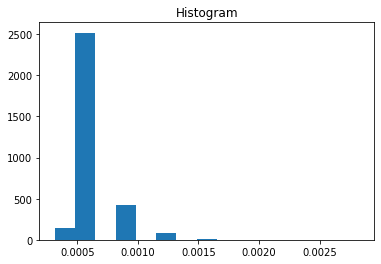

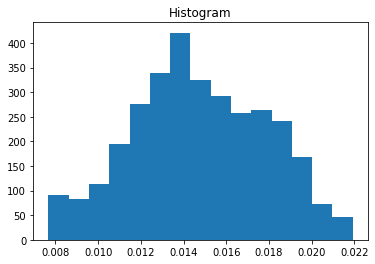

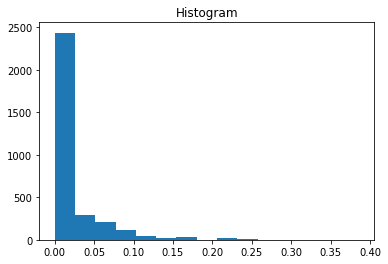

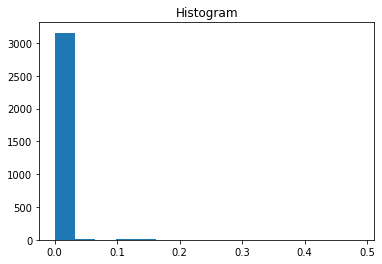

In [107]:
# Distribution of the centralities
def histogram(data, bins):
    plt.title("Histogram")
    plt.hist(data,bins=bins)
    plt.show()

histogram(degree,15)
histogram(closeness,15)
histogram(betweenness,15)
histogram(eigenvector, 15)

In [180]:
def random_attacks(G):
    temp = G.copy()
    connected_component_sizes = []
    while nx.number_of_nodes(temp) > 1:
        node_list = temp.nodes()
        to_delete = random.choice(list(node_list))
        temp.remove_node(to_delete)
        
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
        
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Random attacks")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()
       
def targeted_attacks(G):
    temp = G.copy()
    connected_component_sizes = []
    node_degrees = nx.degree_centrality(temp)
    sorted_node_degrees = sorted(temp.nodes(), key=lambda n: node_degrees[n])
    while nx.number_of_nodes(temp) > 1:
        temp.remove_node(sorted_node_degrees.pop())
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
    
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Targeted attacks")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()

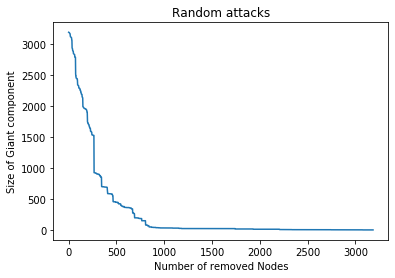

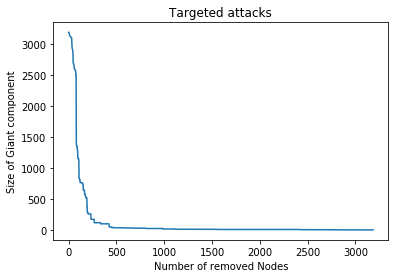

In [181]:
#Incluence of Random or targeted attacks on the remaining size of the Giant component

#Here we could think about using other attack strategies and other dependent variables

random_attacks(G)
targeted_attacks(G)